In [151]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from utils.model_utils import wmape
from sklearn.metrics import mean_absolute_error

In [152]:
df = pd.read_csv(f"/Users/carterdemars/Desktop/nwp/20220101_pv_joined.csv", index_col=0)
df.dropna(subset=['instantaneous_power_W', 'latitude', 'longitude', 'cdir'], axis=0, inplace=True)
for i in range(2,21):
    a = i if len(str(i)) > 1 else '0' + str(i)
    day_df = pd.read_csv(f"/Users/carterdemars/Desktop/nwp/202201{a}_pv_joined.csv", index_col=0)
    day_df.dropna(subset=['instantaneous_power_W', 'latitude', 'longitude', 'cdir'], axis=0, inplace=True)
    df = pd.concat([df, day_df], axis=0, ignore_index=True)

In [153]:
df.wind.unique()

array([nan])

In [154]:
df.drop(['temperature_C', 'voltage', 'dwi', 'wind'], axis=1, inplace=True)

In [155]:
#sns.heatmap(df.drop(['time', 'instantaneous_power_W'], axis=1).corrwith(df['instantaneous_power_W']))

In [156]:
df.head()

,system_id,time,instantaneous_power_W,latitude,longitude,alnid,alnip,aluvd,aluvp,bld,...,tsr,tsrc,ttr,ttrc,u10,u100,u10n,uvb,v10,v100
0,8328,2022-01-01 06:00:00,0.0,41.00,14.25,0.136493,0.128418,0.055422,0.053528,2115.0000,...,0.00,0.00,-944726.60,-935018.56,0.030451,0.255241,0.211633,0.0000,0.321944,0.933605
1,30312,2022-01-01 06:00:00,2.0,37.50,15.00,0.186403,0.179201,0.046982,0.045113,1536.0000,...,0.00,0.00,-925133.20,-923962.50,1.382719,1.857453,1.152041,0.0000,-1.795812,-2.387222
2,29989,2022-01-01 07:00:00,18.0,40.00,18.25,0.122121,0.114193,0.053834,0.052220,6974.5000,...,178847.25,175495.25,-954412.50,-956691.80,1.703351,2.414794,1.685663,11238.1250,-3.481762,-6.293553
3,71633,2022-01-01 07:00:00,159.0,37.75,14.75,0.207172,0.193765,0.053990,0.052348,9828.1875,...,127114.50,127606.50,-924962.70,-938612.50,0.079361,1.194824,0.078454,8186.6094,-2.197811,-3.964417
4,8328,2022-01-01 07:00:00,0.0,41.00,14.25,0.136493,0.128418,0.055408,0.053528,1598.0625,...,53728.00,57379.00,-955964.25,-942700.25,0.277718,0.653505,0.466213,2493.7188,0.325001,0.756270


# Identifying Categorical Data
If we join metadata to the nwp, then we woudl also have categorical features such as panel_brand, orientation, and shade.

In [157]:
categorical_names = ['system_id', 'ptype']
categorical_locs = [df.columns.get_loc(name) for name in categorical_names]
for feature in categorical_names:
 df[feature] = pd.Series(df[feature], dtype="category")

# Specify Model Params

In [158]:
lgbm_params = {
 'subsample_freq': 1,
 'subsample': 1,
 'num_leaves': 30,
 'n_estimators': 1000,
 'min_split_gain': 0.0001,
 'min_child_weight': 0,
 'min_child_samples': 20,
 'max_depth': 10,
 'learning_rate': 0.04,
 'colsample_bytree': 0.5,
 'colsample_bynode': 0.65,
 'categorical_feature': categorical_locs,
}

In [159]:
mdl = LGBMRegressor(**lgbm_params)

# Prepare Training/Testing Data

In [160]:
df['year'] = df['time'].apply(lambda x : int(x[:4]))
df['month'] = df['time'].apply(lambda x : int(x[5:7]))
df['day'] = df['time'].apply(lambda x : int(x[8:10]))
X = df.drop(['instantaneous_power_W', 'time'], axis=1)
y = df['instantaneous_power_W'].astype(float).apply(lambda x: np.maximum(x, 0))

In [161]:
X_train, X_test = X[X['day'] < 15], X[X['day'] >= 15]
y_train = df[df['day'] < 15]['instantaneous_power_W']
y_test = df[df['day'] >= 15]['instantaneous_power_W']

In [162]:
mdl.fit(X_train, y_train)

LGBMRegressor(categorical_feature=[0, 33], colsample_bynode=0.65,
              colsample_bytree=0.5, learning_rate=0.04, max_depth=10,
              min_child_weight=0, min_split_gain=0.0001, n_estimators=1000,
              num_leaves=30, subsample=1, subsample_freq=1)

In [163]:
pred = mdl.predict(X_test)

In [165]:
wmape(y_test, pred)

36.132572670447885

In [166]:
mean_absolute_error(y_test, pred)

592.746591184413

In [169]:
system = random.choice(df['system_id'].unique())
test_indices = X_test[X_test.system_id == system].index
train_indices = X_train[X_train.system_id == system].index

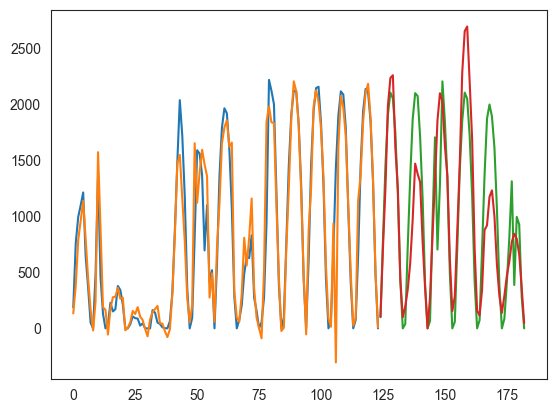

In [170]:
plt.plot(np.arange(len(train_indices)), y_train.loc[train_indices])
plt.plot(np.arange(len(train_indices)), mdl.predict(X_train.loc[train_indices]), label='train_data')
plt.plot(np.arange(len(train_indices), len(train_indices) + len(test_indices)), y_test.loc[test_indices], label='test data')
plt.plot(np.arange(len(train_indices), len(train_indices) + len(test_indices)), mdl.predict(X_test.loc[test_indices]))
#plt.vlines(x=[150], ymin=-10, ymax=3000)

# Feature importances

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

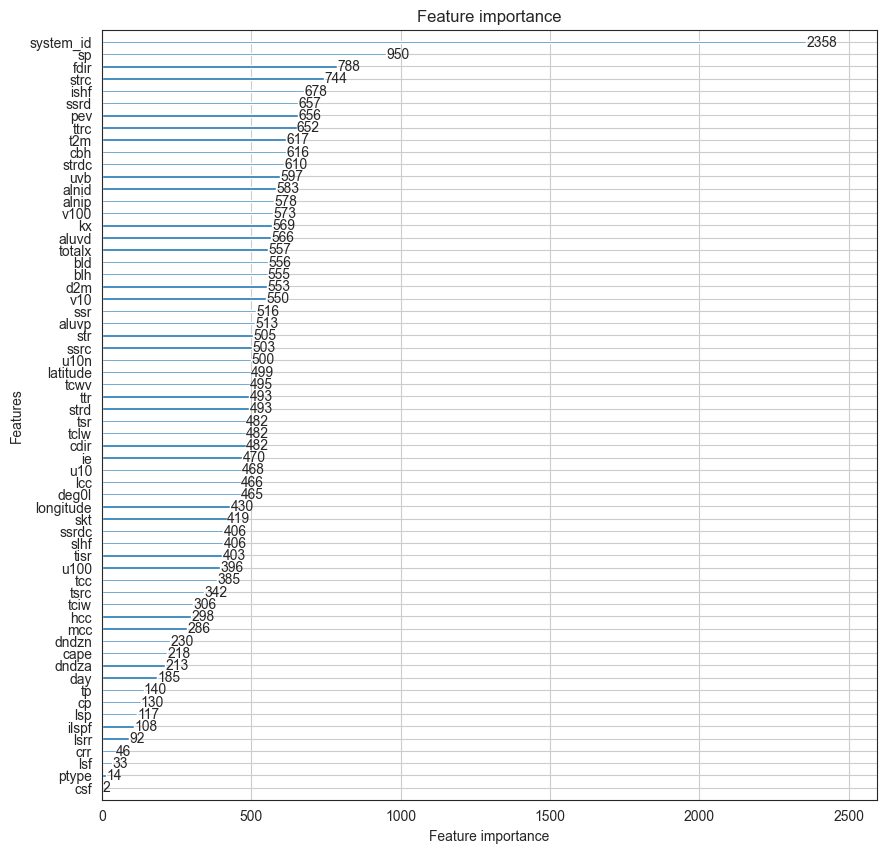

In [171]:
from lightgbm import plot_importance, plot_tree, plot_split_value_histogram
plot_importance(mdl, figsize=(10,10))

SP - surface - pressure seems to be an important feature in this model, even more so that FDIR (total surface radiation) and STRC (clear sky radiation).

In [172]:
mdl.fit(X_train.drop(['sp', 'v10', 'v100', 'u10', 'u100', 'u10n', 'ie'], axis=1), y_train)

LGBMRegressor(categorical_feature=[0, 33], colsample_bynode=0.65,
              colsample_bytree=0.5, learning_rate=0.04, max_depth=10,
              min_child_weight=0, min_split_gain=0.0001, n_estimators=1000,
              num_leaves=30, subsample=1, subsample_freq=1)

In [173]:
pred = mdl.predict(X_test.drop(['sp', 'v10', 'v100', 'u10', 'u100', 'u10n', 'ie'], axis=1))

In [174]:
wmape(y_test, pred)

34.160790444886246

In [175]:
mean_absolute_error(y_test, pred)

560.399954718209

In [176]:
wmape(y_train, mdl.predict(X_train.drop(['sp', 'v10', 'v100', 'u10', 'u100', 'u10n', 'ie'], axis=1)))

17.98447211666172

In [177]:
mean_absolute_error(y_train, mdl.predict(X_train.drop(['sp', 'v10', 'v100', 'u10', 'u100', 'u10n', 'ie'], axis=1)))

225.4300718600493

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

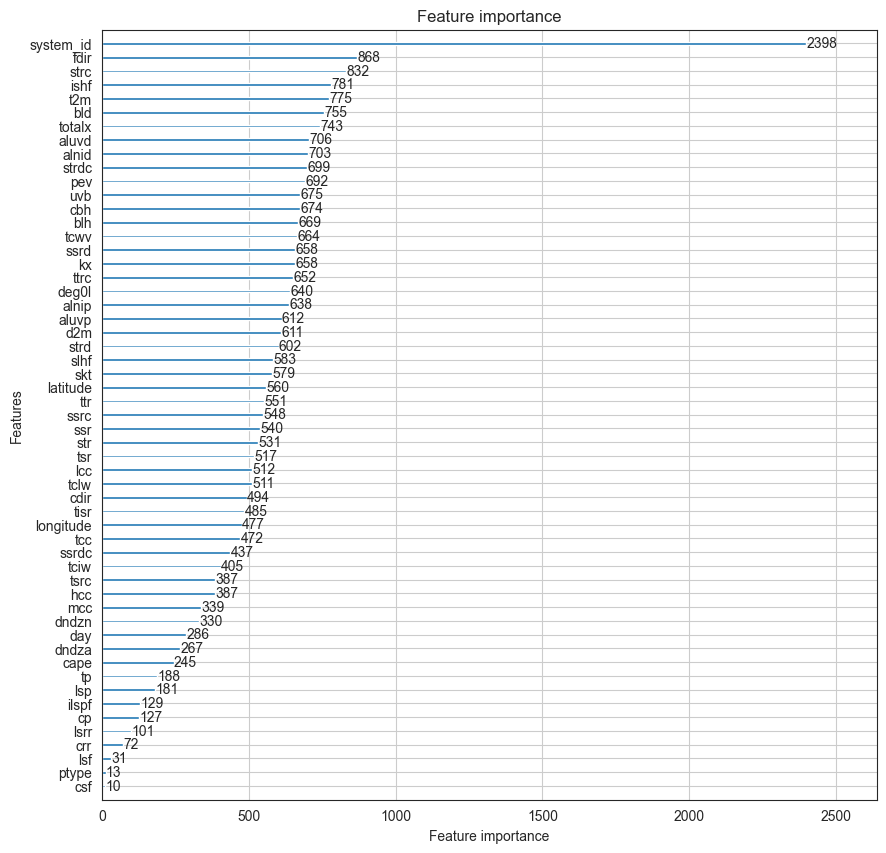

In [178]:
from lightgbm import plot_importance, plot_tree, plot_split_value_histogram
plot_importance(mdl, figsize=(10,10))

# Optuna HPT

In [83]:
X_train, X_test = X[X['day'] < 15], X[X['day'] >= 15]
y_train = df[df['day'] < 15]['instantaneous_power_W']
y_test = df[df['day'] >= 15]['instantaneous_power_W']

In [179]:
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
import optuna

# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        'objective': 'regression_l1',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 256),
        'n_estimators': trial.suggest_int('num_iterations', 100, 1000),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    }

    mdl = lgb.train(param, dtrain)

    return wmape(y_test, mdl.predict(X_test))

# 3. Create a study object and optimize the objective function.
dtrain = lgb.Dataset(X_train, y_train)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2023-07-05 17:00:00,658] A new study created in memory with name: no-name-d5743858-deba-46f6-b74e-faa181d0f212
[I 2023-07-05 17:00:08,008] Trial 0 finished with value: 31.993914565455153 and parameters: {'lambda_l1': 1.1588142913867736, 'lambda_l2': 7.606992415027862e-07, 'num_leaves': 25, 'num_iterations': 488, 'feature_fraction': 0.7070449468196476, 'bagging_fraction': 0.9947785822606355, 'bagging_freq': 4, 'max_depth': 8, 'learning_rate': 0.0293145170883526}. Best is trial 0 with value: 31.993914565455153.
[I 2023-07-05 17:00:49,827] Trial 1 finished with value: 31.413140512813563 and parameters: {'lambda_l1': 1.8551726198943193e-05, 'lambda_l2': 4.923530783408018e-06, 'num_leaves': 187, 'num_iterations': 926, 'feature_fraction': 0.9672497971810572, 'bagging_fraction': 0.5171345859317984, 'bagging_freq': 1, 'max_depth': 13, 'learning_rate': 0.03471332139734145}. Best is trial 1 with value: 31.413140512813563.
[I 2023-07-05 17:00:57,464] Trial 2 finished with value: 33.99708591613

In [180]:
opt_params = study.best_trial.params

In [181]:
opt_mdl = LGBMRegressor(**opt_params)

In [182]:
opt_mdl.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=1.8551726198943193e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8551726198943193e-05
[LightGBM] [Warning] feature_fraction is set=0.9672497971810572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9672497971810572
[LightGBM] [Warning] bagging_fraction is set=0.5171345859317984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5171345859317984
[LightGBM] [Warning] lambda_l2 is set=4.923530783408018e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.923530783408018e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMRegressor(bagging_fraction=0.5171345859317984, bagging_freq=1,
              feature_fraction=0.9672497971810572,
              lambda_l1=1.8551726198943193e-05, lambda_l2=4.923530783408018e-06,
              learning_rate=0.03471332139734145, max_depth=13,
              num_iterations=926, num_leaves=187)

In [184]:
pred = opt_mdl.predict(X_test)

In [185]:
wmape(y_test, pred)

29.320856322282143

In [186]:
wmape(y_train, opt_mdl.predict(X_train))

6.825846341030245


TODO
1) Feature selection test
- look into RFE for pruning (recursive feature elimination in sklearn)
- we want to identify the subset of features that results in the best performing model (we will need 1+ years of data to do this, and will want to cross-validate using different sites and also different subsets of the features)
2) Feature engineering task
- we want to generate Fourier feature for each PV sites (we will force period to be 365.25 for one of them)
- similar to sinusoidal regression
- we want to generate some unique features to each site based on historical PV output and metadata (average daily output, theoretical maximum daily output)
- scrape features from metadata (shade, orientation, panel brand, number of panels,panel_capacity_W_each)
3) Optuna HPT
- experiment with different boosting types (gbdt, dart, rf), and different methods of regulating overfitting (lambda params, max depth param, etc... will need to research for this)
- we will also want to use cross validation and probably early-stopping to avoid overfitting
4) Error exploration
- look at distribution of MAE, WMAPE
- Are outliers caused by outliers in our targets or outliers in our predictions?
- Check for negative predictions
- Compare predicted vs true value - where is lgbm going "wrong"? Does it tend to underpredict? Overpredict? Does it predict 0 at the right times? Is it properly adapting to spikes in power generation?
5) Data Task
- get 2 years data uploaded to GCP

In [187]:
mae = np.abs(y_test-pred)
#mae = mae[mae < 2000]

In [188]:
mae.max()

31509.045942085544

In [189]:
mae.sum()/len(mae)

481.00194232378334

In [190]:
mae = mae[mae < 2000]

In [191]:
mae.sum()/len(mae)

306.9140365414852

In [118]:
cmap = sns.diverging_palette(10, 500, as_cmap=True)

In [121]:
corr = df.drop(['time', 'instantaneous_power_W', 'system_id'], axis=1).corrwith(df['instantaneous_power_W'])
corr = pd.DataFrame(corr)

<AxesSubplot: >

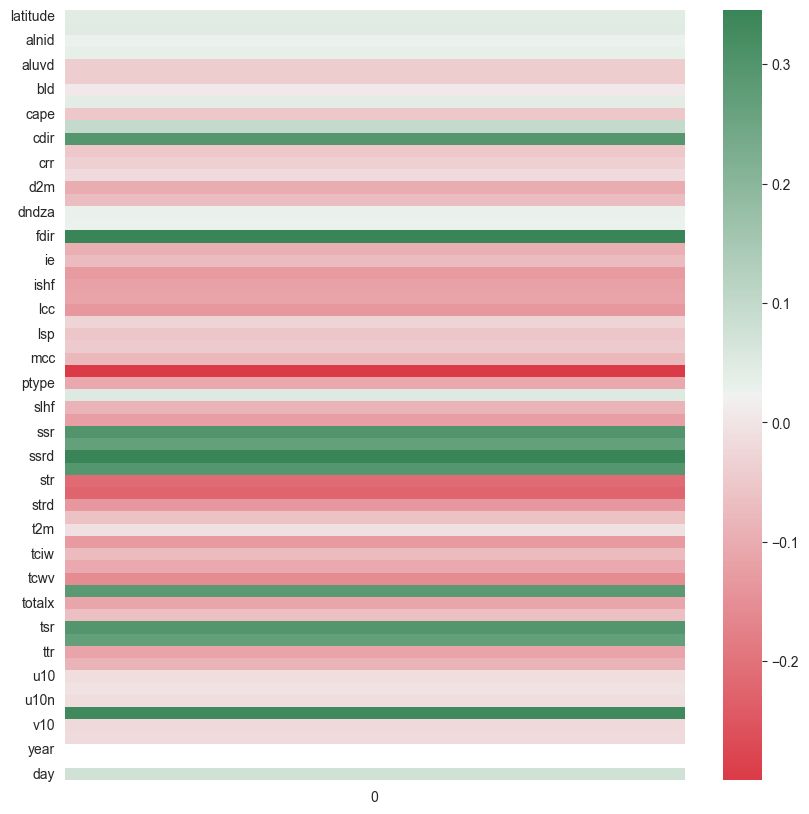

In [122]:
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap=cmap)

In [140]:
c = df.drop('time',axis=1).corr()

<AxesSubplot: >

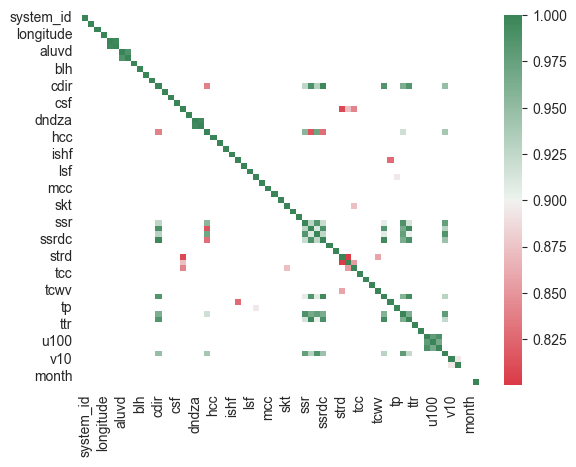

In [144]:
sns.heatmap(c[c>0.8])